FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='10', scene='static_Complex', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='10', scene='static_Medium', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='10', scene='static_Simple', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='11', scene='static_Complex', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='11', scene='static_Medium', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='11', scene='static_Simple', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='12', scene='static_Complex', decision_period=1)
FilenameParts(agent='HanningAO', model='hanning-ao-no-los-dynamic', model_id='12', scene='static_Medium', decision_period=

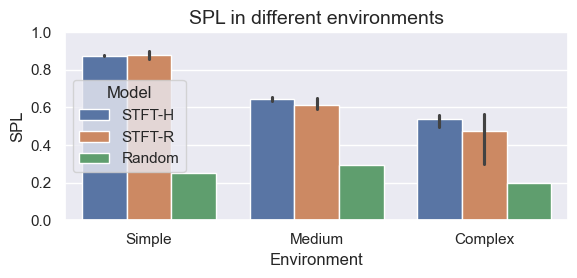

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
from parse_name import parse_filename

base_path = r"../logs"
files = glob.glob(f"{base_path}/*.csv")
MAX_STEPS = 1000
spl_totals = []
sns.set()

for file in files:
    metadata = parse_filename(file)
    print(metadata)

    df = pd.read_csv(file, sep=";", decimal=",")
    string_cols = ["ClipName"]
    for col in df.columns:
        if col not in string_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    shortest_path = df.groupby("Episode")["PathLength"].first()
    df["FullPath"] = shortest_path

    cols = ["AgentPositionY", "AgentPositionX", "AgentPositionZ"]
    diffs_per_episode = df.groupby(['Episode'], as_index=True)[cols].diff().fillna(0)
    df["DeltaDistance"] = np.sqrt((diffs_per_episode ** 2).sum(axis=1))
    df["Steps"] = df.groupby("Episode")["DeltaDistance"].transform("count")

    travelled = df.groupby("Episode")["DeltaDistance"].sum()
    threshold = 10
    travelled_with_threshold = travelled + threshold

    steps_per_episode = df.groupby("Episode")["Steps"].first()
    success = steps_per_episode <= MAX_STEPS

    spl = success.astype(int) * (shortest_path / pd.DataFrame({'a': shortest_path, 'b': travelled_with_threshold}).max(axis=1))
    spl_total = spl.sum() / len(spl)

    model = metadata.model
    if "rect" in model:
        model = "STFT-R"
    elif "hanning" in model:
        if "dynamic" in model:
            model = "STFT-H dynamic"
            continue
        else:
            model = "STFT-H"
    elif "random" in model:
        model = "Random"
    # model = metadata.model + "_" + str(metadata.decision_period)
    # environment = metadata.scene + "_" + str(metadata.decision_period)  # In this evaluation, we want to see the effect of decision period
    environment = metadata.scene
    environment = environment.replace("static_", "")
    spl_totals.append({"Environment": environment, "Model": model, "SPL": spl_total})

# Convert the list of dictionaries to a DataFrame
sorted_spl_totals = pd.DataFrame(spl_totals)

# Ensure hue order is applied correctly
hue_order = ["STFT-H", "STFT-R", "Random"]

sorted_spl_totals["Model"] = pd.Categorical(sorted_spl_totals["Model"], categories=hue_order, ordered=True)

# Sort the DataFrame by SPL values
sorted_spl_totals = sorted_spl_totals.sort_values(by='Environment', ascending=False)

# Set font size for all text elements
font_size = 14
plt.rcParams.update({'font.size': font_size})

# plt.figure()
plt.figure(figsize=(6, 3))  # Adjust the size of the figure (width, height)
plt.ylim(0, 1)
# sns.set_context("notebook", font_scale=1.2)  # Moderate font size
sns.barplot(x="Environment", y="SPL", hue="Model", data=sorted_spl_totals)
plt.title("SPL in different environments", fontsize=14)  # Increase title font size
plt.xlabel("Environment")
plt.ylabel("SPL")
plt.legend(title='Model')
plt.tight_layout()
plt.savefig("spl.png")
plt.savefig("spl.pdf")
plt.show()
